In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
df = web.DataReader('AAPL', data_source='yahoo', start='2010-01-04', end='2016-12-30') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.466835
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.512596
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.090879
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.042646
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.215786
...,...,...,...,...,...,...
2016-12-23,116.519997,115.589996,115.589996,116.519997,14249500.0,110.743988
2016-12-27,117.800003,116.489998,116.519997,117.260002,18296900.0,111.447319
2016-12-28,118.019997,116.199997,117.519997,116.760002,20905900.0,110.972122


In [3]:
df.shape

(1762, 6)

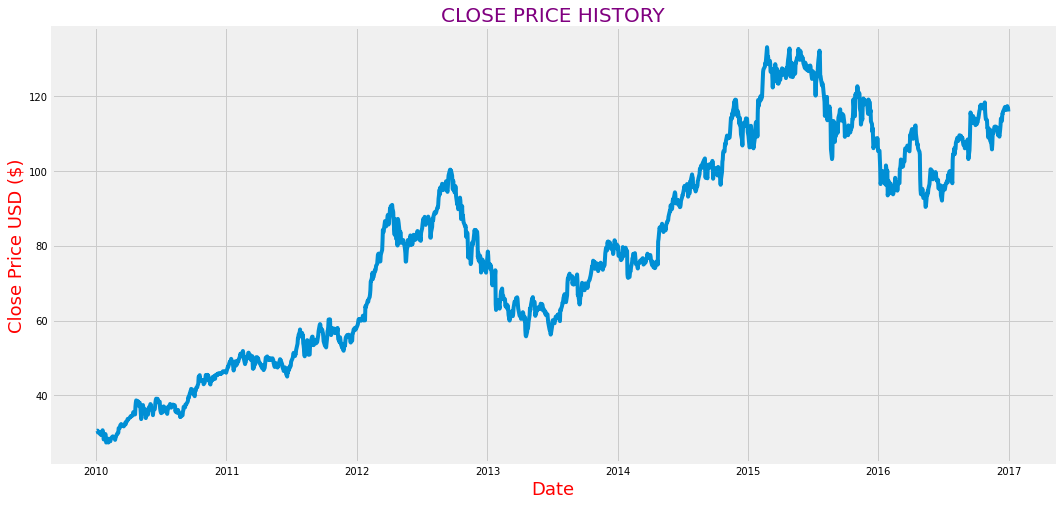

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('CLOSE PRICE HISTORY',fontsize=20,color='purple')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18,COLOR='RED')
plt.ylabel('Close Price USD ($)',fontsize=18,COLOR='RED')
plt.show()

In [5]:
#Here the close price was very low during 2010 and then it increased but again there is a decrease but in between 2015 and 2016 it was highest closing price .

In [6]:
#Create a new dataframe with only the 'Close' column
df2 = df.filter(['Close'])
#Converting the dataframe to a numpy array
array1 = df2.values
#Get /Compute the number of rows to train the model on
train_df2 = math.ceil( len(array1) *.8) 

In [7]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(array1)

In [8]:
#Create the scaled training data set 
train = scaled_data[0:train_df2  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train)):
    x_train.append(train[i-60:i,0])
    y_train.append(train[i,0])

In [9]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [11]:
#Build the LSTM network model
md = Sequential()
md.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
md.add(LSTM(units=50, return_sequences=False))
md.add(Dense(units=25))
md.add(Dense(units=1))

In [12]:
#Compile the model
md.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
#Train the model
md.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1350/1350 [==============================] - 47s 35ms/step - loss: 0.0025


In [14]:
#Test data set
test_data = scaled_data[train_df2 - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  test_data[train_df2 : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
test_data.shape

(412, 1)

In [16]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [17]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [18]:
#Getting the models predicted price values
predictions = md.predict(x_test) 
predict = scaler.inverse_transform(predictions)#Undo scaling

In [26]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean((predict- y_test)**2))
rmse

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


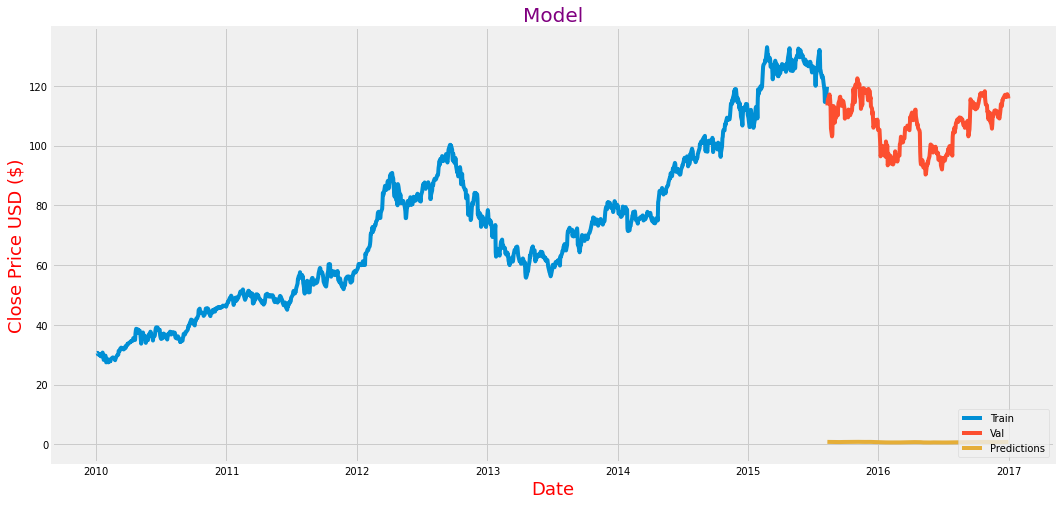

In [21]:
#Plot/Create the data for the graph
train1 = df2[:train_df2]
valid = df2[train_df2:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model',fontsize=20,color='purple')
plt.xlabel('Date', fontsize=18,color='red')
plt.ylabel('Close Price USD ($)', fontsize=18,color='red')
plt.plot(train1['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2015-08-11,113.489998,0.802561
2015-08-12,115.239998,0.796756
2015-08-13,115.150002,0.792005
2015-08-14,115.959999,0.788089
2015-08-17,117.160004,0.785603
...,...,...
2016-12-23,116.519997,0.781699
2016-12-27,117.260002,0.784005
2016-12-28,116.760002,0.786259


In [23]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2010-01-04', end='2016-12-29')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = md.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[110.723434]]


In [24]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2016-12-30', end='2016-12-30')
print(apple_quote2['Close'])

Date
2016-12-30    115.82
Name: Close, dtype: float64


In [25]:
#Conclusion 
#As here from the start date='2010-01-04'and end date ='2016-12-29' was taken ,i have predicted the 
#stock price of the next day of 2016-12-29 which is 2016-12-30 and the predicted price is 115.82.